# Postprocessing pipeline with SpikeInterface

In [1]:
# Parameters

bin_data_path = r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\binary_files\Wifi_20240430_good_heatmap.bin"
sorted_data_path = r"C:\Users\boninilab\Desktop\kilosort-test\sorting-test-Wifi_20240430\kilosort4_output_tests\Wifi_20240430_test4"
probe_file_path = "wifi_channel_map_kilosort.prb"
sampling_frequency = 32000.0  
num_channels = 128  
dtype = "uint16"
voltage_res = 0.2 # see deuteron info
acd_bits = 16 # see deuteron info

# Time window for the waveforms / templates
ms_before = 1.0
ms_after = 2.0




In [2]:
# ===========================================================================
# Testing the postprocessing pipeline analyses for the sorted Wifi_20240430 session with kilosort4
# ===========================================================================
import spikeinterface as si


import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Loading the bin data 
file_path = Path(bin_data_path)

# Confirm file existence
assert file_path.is_file(), f"Error: {file_path} is not a valid file. Please check the path."

# Define recording parameters
gain_to_uV = voltage_res
offset_to_uV = - 2 ** (acd_bits - 1) * gain_to_uV

# Load data using SpikeInterface
recording = si.read_binary(
    file_paths=file_path,
    sampling_frequency=sampling_frequency,
    num_channels=num_channels,
    dtype=dtype,
    gain_to_uV=gain_to_uV,
    offset_to_uV=offset_to_uV
)

# Load the probe configuration
from probeinterface import read_prb

probe_file = Path(probe_file_path)
probe = read_prb(probe_file)

recording.set_probegroup(probe, in_place=True)

recording

BinaryRecordingExtractor: 128 channels - 32.0kHz - 1 segments - 128,791,427 samples 
                          4,024.73s (1.12 hours) - uint16 dtype - 30.71 GiB
  file_paths: ['C:\\Users\\boninilab\\Desktop\\kilosort-test\\sorting-test-Wifi_20240430\\binary_files\\Wifi_20240430_good_heatmap.bin']

In [3]:
# Load the sorting result from kilosort4/phy
from spikeinterface.extractors import read_phy

sorting_path = Path(sorted_data_path)
sorting = read_phy(sorting_path, exclude_cluster_groups=['noise', 'mua'])
sorting.set_property("group", sorting.get_property("channel_group"))
sorting

PhySortingExtractor: 31 units - 1 segments - 32.0kHz

In [4]:
# Create the SortingAnalyzer
analyzer = si.create_sorting_analyzer(
    sorting=sorting,
    recording=recording,
    sparse=True, # Use a sparape representation, so keeps only info of relevant channel(s)
    # Args for estimate_sparsity function
    num_spikes_for_sparsity=1000,
    peak_sign="neg",
    ms_before=ms_before,
    ms_after=ms_after,
    method="best_channels",
    num_channels=1, # Select the single best channel, i.e. the one the sorting associates to the unit/cluster in kilosort
    amplitude_mode="peak_to_peak", # select based on the difference betwenne min amplitude and max amplitude
    format="memory", # Keep on memeory, saved to sika just the final results
)

print(analyzer)

estimate_sparsity (no parallelization):   0%|          | 0/4025 [00:00<?, ?it/s]

SortingAnalyzer: 128 channels - 31 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions


In [5]:
# Compute the sorting metrics
job_kwargs = dict(n_jobs=8, chunk_duration="2s", progress_bar=True)
compute_dict = {
    'random_spikes': {'method': 'uniform', 'max_spikes_per_unit': 5000},
    'waveforms': {'ms_before': ms_before, 'ms_after': ms_after, "dtype": "float32"},
    'templates': {'operators': ["average"]}
}
analyzer.compute(compute_dict, **job_kwargs)

analyzer

compute_waveforms (workers: 8 processes):   0%|          | 0/2013 [00:00<?, ?it/s]

SortingAnalyzer: 128 channels - 31 units - 1 segments - memory - sparse - has recording
Loaded 3 extensions: random_spikes, waveforms, templates

In [6]:
ext_templates = analyzer.get_extension("templates")

av_templates = ext_templates.get_data(operator="average")
print("Templates shape: ", av_templates.shape)

Templates shape:  (31, 96, 128)


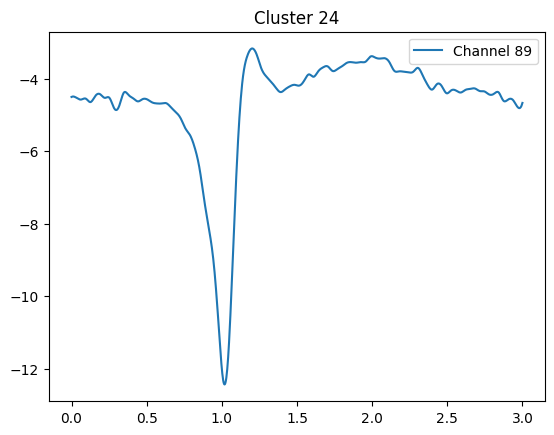

Time to peak:  0.18318318318318316


In [7]:
cluster_ids = sorting.get_unit_ids()
unit_id = 24
channel_id = analyzer.sparsity.unit_id_to_channel_ids[unit_id][0]

fig, ax = plt.subplots()
unit_index = np.where(np.array(cluster_ids) == unit_id)[0][0]
template = av_templates[unit_index]

from scipy.interpolate import interp1d

# Define original and target time points
npoints = 1000
original_times = np.linspace(0., 3., 96)  # Original 96 points
target_times = np.linspace(0., 3., npoints)  # Target 1000 points

# Create interpolation function (cubic gives smoother results)
f = interp1d(original_times, template[:,channel_id], kind='cubic')
# Apply interpolation to get upsampled template
template_upsampled = f(target_times)

wf_times = np.linspace(0., 3., npoints)

ax.plot(wf_times, template_upsampled, label=f"Channel {channel_id}")
ax.set_title(f"Cluster {unit_id}")
plt.legend()

plt.show()

tr_idx = np.argmin(template_upsampled)
pk_idx = tr_idx + np.argmax(template_upsampled[tr_idx:])
ttp = wf_times[pk_idx] - wf_times[tr_idx]
print("Time to peak: ", ttp)

In [8]:
analyzer.compute(
    input="template_metrics", upsampling_factor=npoints,
    delete_existing_metrics=True,
    sparsity=analyzer.sparsity
)

analyzer.get_extension("template_metrics").get_data()

c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\boninilab\miniconda3\envs\spikeinterface\Lib\site-packages\scipy\stats\_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


,,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks
unit_id,channel_id,,,,,,,
0,33,0.001978,0.000249,0.000473,<NA>,<NA>,0,3
1,9,0.000754,-0.190156,0.000294,166725.32317,-13444.433777,0,1
4,20,0.000767,-0.28653,0.000307,82078.360615,-11611.273179,1,1
5,16,0.000632,-0.216035,0.000284,356721.988477,-15985.676244,1,1
6,16,0.000754,-0.148367,0.000275,31761.702495,-787.195376,0,1
7,4,0.000394,-0.222095,0.000152,196432.97313,-9154.87137,1,1
8,21,0.000582,-0.100634,0.000229,346360.825993,-14093.809408,0,1
9,29,0.000439,-0.070836,0.000259,468788.758439,-6151.142491,0,1
10,21,0.000698,-0.092316,0.000251,72197.2724,-3884.365073,0,1


numpy.ndarray

In [9]:
spk_times = sorting.get_unit_spike_train(unit_id=1, return_times=True)

In [10]:
spk_times[333:350]

array([204.72109375, 211.0305    , 211.08978125, 211.1665625 ,
       211.51965625, 211.62140625, 211.75625   , 213.0785    ,
       213.13778125, 213.2145625 , 213.56765625, 213.66940625,
       213.80425   , 219.625625  , 220.299625  , 220.36078125,
       221.67359375])